In [37]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import timedelta
import gc # Garbage Collector

# Import GCS library
from google.cloud import storage

from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
# Updated imports for multiclass evaluation
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder # Added LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from collections import Counter

In [39]:
# Define time windows and lookback periods
TIME_WINDOW_HOURS = 24
PRIOR_ANTIBIOTIC_LOOKBACK_DAYS = 30
TOP_N_PAIRS = 10
N_SPLITS_CV = 5

In [2]:
# Define required CSV files and their paths
gcs_paths = {
    "micro": "gs://msai/aih/MICROBIOLOGYEVENTS.csv.gz", 
    "patients": "gs://msai/aih/PATIENTS.csv.gz",
    "admissions": "gs://msai/aih/ADMISSIONS.csv.gz",
    "labevents": "gs://msai/aih/LABEVENTS.csv.gz",
    "chartevents": "gs://msai/aih/CHARTEVENTS.csv.gz",
    "prescriptions": "gs://msai/aih/PRESCRIPTIONS.csv.gz",
    "diagnoses": "gs://msai/aih/DIAGNOSES_ICD.csv.gz"
}

In [3]:
# Define dtypes for memory efficiency
# Using appropriate integer types and 'category' can save significant memory
dtypes_micro = {
    'SUBJECT_ID': 'int32', 'HADM_ID': 'float32',
    'SPEC_ITEMID': 'float32', 'ORG_ITEMID': 'float32', 'AB_ITEMID': 'float32',
    'ISOLATE_NUM': 'float32', 'DILUTION_VALUE': 'float32',
    'SPEC_TYPE_DESC': 'category', 'ORG_NAME': 'category', 'AB_NAME': 'category',
    'INTERPRETATION': 'category'
}
dtypes_patients = {'SUBJECT_ID': 'int32', 'GENDER': 'category'}
dtypes_admissions = {
    'SUBJECT_ID': 'int32', 'HADM_ID': 'int32',
    'ADMISSION_TYPE': 'category', 'ETHNICITY': 'category'
}
dtypes_labevents = {
    'SUBJECT_ID': 'int32', 'HADM_ID': 'float32', 'ITEMID': 'int32',
    'VALUE': 'object', 'VALUENUM': 'float32', 'VALUEUOM': 'category', 'FLAG': 'category'
}
dtypes_chartevents = {
    'SUBJECT_ID': 'int32', 'HADM_ID': 'float32', 'ICUSTAY_ID': 'float32', 'ITEMID': 'int32',
    'VALUE': 'object', 'VALUENUM': 'float32', 'VALUEUOM': 'category', 'WARNING': 'float32',
    'ERROR': 'float32', 'RESULTSTATUS': 'category', 'STOPPED': 'category'
}
dtypes_prescriptions = {
    'SUBJECT_ID': 'int32', 'HADM_ID': 'int32', 'ICUSTAY_ID': 'float32',
    'DRUG_TYPE': 'category', 'DRUG': 'category', 'ROUTE': 'category'
}
dtypes_diagnoses = {
    'SUBJECT_ID': 'int32', 'HADM_ID': 'int32', 'SEQ_NUM': 'float32', 'ICD9_CODE': 'category'
}

In [40]:
def load_csv_from_gcs(gcs_path, dtypes=None, parse_dates=None, usecols=None):
    df = pd.read_csv(gcs_path, dtype=dtypes, parse_dates=parse_dates, usecols=usecols, compression='gzip', low_memory=False)
    print(f"Loaded {len(df)} rows.")
    return df

In [41]:
df_micro = load_csv_from_gcs(gcs_paths['micro'], dtypes=dtypes_micro, parse_dates=['CHARTTIME', 'CHARTDATE'])

Loaded 631726 rows.


In [42]:
# Common values are R, S, I (Intermediate).
RELEVANT_INTERPRETATIONS = ['R', 'S', 'I']

In [43]:
# Filter for relevant interpretations and non-null org/ab names
df_micro_filtered = df_micro[
    df_micro['INTERPRETATION'].isin(RELEVANT_INTERPRETATIONS) & # Use the list
    df_micro['ORG_NAME'].notna() &
    df_micro['AB_NAME'].notna()
].copy()

In [44]:
# Count pairs based on these interpretations
top_pairs_df = df_micro_filtered.groupby(['ORG_NAME', 'AB_NAME']).size().reset_index(name='PAIR_COUNT')
top_pairs_df = top_pairs_df.sort_values('PAIR_COUNT', ascending=False).head(TOP_N_PAIRS)

/var/tmp/ipykernel_16006/4283320187.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  top_pairs_df = df_micro_filtered.groupby(['ORG_NAME', 'AB_NAME']).size().reset_index(name='PAIR_COUNT')


In [45]:
top_pairs_df.head(10)

,ORG_NAME,AB_NAME,PAIR_COUNT
9620,STAPH AUREUS COAG +,OXACILLIN,8546
9614,STAPH AUREUS COAG +,GENTAMICIN,7555
9616,STAPH AUREUS COAG +,LEVOFLOXACIN,7523
9613,STAPH AUREUS COAG +,ERYTHROMYCIN,7247
9611,STAPH AUREUS COAG +,CLINDAMYCIN,5659
9626,STAPH AUREUS COAG +,TETRACYCLINE,4699
9621,STAPH AUREUS COAG +,PENICILLIN,4620
9629,STAPH AUREUS COAG +,VANCOMYCIN,4614
9625,STAPH AUREUS COAG +,RIFAMPIN,4434
4064,ESCHERICHIA COLI,GENTAMICIN,4220


In [12]:
# Load tables that don't depend on the specific pair first to avoid reloading in loop
print("\nLoading base static tables...")
df_patients = load_csv_from_gcs(gcs_paths['patients'], dtypes=dtypes_patients, parse_dates=['DOB'])
df_admissions = load_csv_from_gcs(gcs_paths['admissions'], dtypes=dtypes_admissions, parse_dates=['ADMITTIME', 'DISCHTIME'])
df_diagnoses_full = load_csv_from_gcs(gcs_paths['diagnoses'], dtypes=dtypes_diagnoses)
df_prescriptions_full = load_csv_from_gcs(gcs_paths['prescriptions'], dtypes=dtypes_prescriptions, parse_dates=['STARTDATE', 'ENDDATE'])


Loading base static tables...
Loaded 46520 rows.
Loaded 58976 rows.
Loaded 651047 rows.
Loaded 4156450 rows.


In [13]:
# --- Load Large Event Tables Once (very memory intensive) ---
# loading these within the loop because memory is constrained.
print("\nLoading large event tables (may take time and memory)...")
df_labevents_full = load_csv_from_gcs(gcs_paths['labevents'], dtypes=dtypes_labevents, parse_dates=['CHARTTIME'])
# df_chartevents_full = load_csv_from_gcs(gcs_paths['chartevents'], dtypes=dtypes_chartevents, parse_dates=['CHARTTIME'])



Loading large event tables (may take time and memory)...
Loaded 27854055 rows.


In [15]:
# Check if all dataframes loaded successfully
if any(df is None for df in [df_patients, df_admissions, df_diagnoses_full, df_prescriptions_full, df_labevents_full]):
    print("One or more required base CSV files failed to load.")

In [18]:
# --- Initialize Label Encoder for the Target Variable ---
target_encoder = LabelEncoder()
target_encoder.fit(RELEVANT_INTERPRETATIONS)
print(f"Target classes encoded as: {dict(zip(target_encoder.classes_, target_encoder.transform(target_encoder.classes_)))}")

Target classes encoded as: {np.str_('I'): np.int64(0), np.str_('R'): np.int64(1), np.str_('S'): np.int64(2)}


In [51]:
results_store = dict()


--- Starting Analysis Loop for Top Pairs ---

================ Processing Pair 9621/10: STAPH AUREUS COAG + / OXACILLIN ================

Processing data for STAPH AUREUS COAG + / OXACILLIN...


/var/tmp/ipykernel_16006/2980027711.py:64: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_labevents_filtered['HADM_ID'] = df_labevents_filtered['HADM_ID'].astype(int)


Finished processing for STAPH AUREUS COAG + / OXACILLIN. Final DataFrame shape: (7553, 14)

--- Starting EDA for STAPH AUREUS COAG + / OXACILLIN ---

Target variable distribution (INTERPRETATION):
{'R': 4499, 'S': 3054, 'P': 0, 'I': 0}

--- Applying Outlier Capping for STAPH AUREUS COAG + / OXACILLIN ---

--- Starting Preprocessing for STAPH AUREUS COAG + / OXACILLIN ---

--- Starting Model Training & Validation for STAPH AUREUS COAG + / OXACILLIN ---
Performing Cross-Validation...


/var/tmp/ipykernel_16006/2980027711.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_diagnoses_filtered['DIABETES_FLAG'] = df_diagnoses_filtered['ICD9_CODE'].str.startswith('250').astype(int)


Mean CV F1-Weighted: 0.6938
Training final model...

--- Evaluating Model for STAPH AUREUS COAG + / OXACILLIN ---

Classification Report:
              precision    recall  f1-score   support

           R       0.74      0.85      0.79      1125
           S       0.72      0.55      0.63       764

    accuracy                           0.73      1889
   macro avg       0.73      0.70      0.71      1889
weighted avg       0.73      0.73      0.72      1889

Test Set F1-Weighted Score: 0.7249

Confusion Matrix:


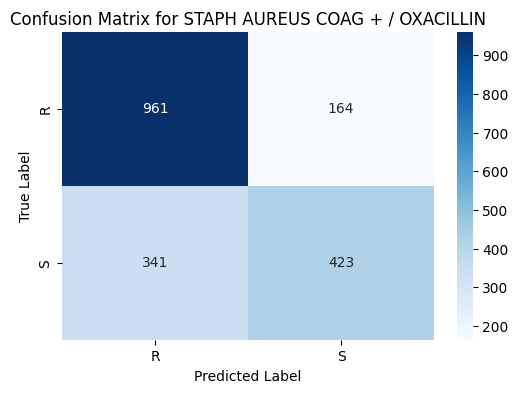


--- Generating Insights for STAPH AUREUS COAG + / OXACILLIN ---

Top 5 Most Important Features:
                    Feature  Importance
0          AGE_AT_ADMISSION    0.199448
2          AVG_WBC_FIRST24H    0.184009
1   AVG_CREATININE_FIRST24H    0.169929
3  AVG_BICARBONATE_FIRST24H    0.168549
5              HAS_DIABETES    0.022445

================ Processing Pair 9615/10: STAPH AUREUS COAG + / GENTAMICIN ================

Processing data for STAPH AUREUS COAG + / GENTAMICIN...


/var/tmp/ipykernel_16006/2980027711.py:64: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_labevents_filtered['HADM_ID'] = df_labevents_filtered['HADM_ID'].astype(int)
/var/tmp/ipykernel_16006/2980027711.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_diagnoses_filtered['DIABETES_FLAG'] = df_diagnoses_filtered['ICD9_CODE'].str.startswith('250').astype(int)


Finished processing for STAPH AUREUS COAG + / GENTAMICIN. Final DataFrame shape: (6742, 14)

--- Starting EDA for STAPH AUREUS COAG + / GENTAMICIN ---

Target variable distribution (INTERPRETATION):
{'S': 6521, 'R': 199, 'I': 22, 'P': 0}

--- Applying Outlier Capping for STAPH AUREUS COAG + / GENTAMICIN ---

--- Starting Preprocessing for STAPH AUREUS COAG + / GENTAMICIN ---

--- Starting Model Training & Validation for STAPH AUREUS COAG + / GENTAMICIN ---
Performing Cross-Validation...
Mean CV F1-Weighted: 0.9666
Training final model...

--- Evaluating Model for STAPH AUREUS COAG + / GENTAMICIN ---

Classification Report:
              precision    recall  f1-score   support

           I       0.00      0.00      0.00         5
           R       0.93      0.28      0.43        50
           S       0.98      1.00      0.99      1631

    accuracy                           0.97      1686
   macro avg       0.64      0.43      0.47      1686
weighted avg       0.97      0.97      0.97

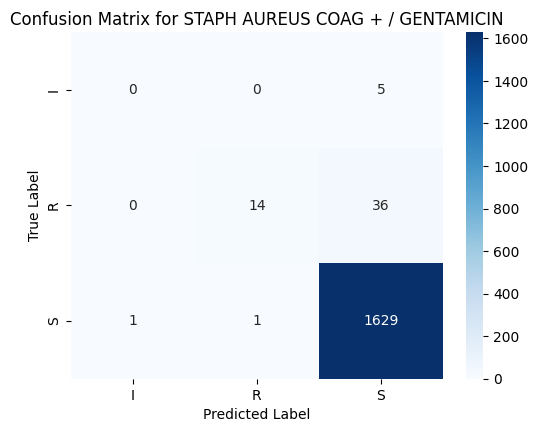


--- Generating Insights for STAPH AUREUS COAG + / GENTAMICIN ---

Top 5 Most Important Features:
                    Feature  Importance
1   AVG_CREATININE_FIRST24H    0.167109
0          AGE_AT_ADMISSION    0.165230
2          AVG_WBC_FIRST24H    0.151905
3  AVG_BICARBONATE_FIRST24H    0.135805
4     HAD_PRIOR_ANTIBIOTICS    0.047818

================ Processing Pair 9617/10: STAPH AUREUS COAG + / LEVOFLOXACIN ================

Processing data for STAPH AUREUS COAG + / LEVOFLOXACIN...


/var/tmp/ipykernel_16006/2980027711.py:64: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_labevents_filtered['HADM_ID'] = df_labevents_filtered['HADM_ID'].astype(int)
/var/tmp/ipykernel_16006/2980027711.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_diagnoses_filtered['DIABETES_FLAG'] = df_diagnoses_filtered['ICD9_CODE'].str.startswith('250').astype(int)


Finished processing for STAPH AUREUS COAG + / LEVOFLOXACIN. Final DataFrame shape: (6717, 14)

--- Starting EDA for STAPH AUREUS COAG + / LEVOFLOXACIN ---

Target variable distribution (INTERPRETATION):
{'R': 4158, 'S': 2463, 'I': 96, 'P': 0}

--- Applying Outlier Capping for STAPH AUREUS COAG + / LEVOFLOXACIN ---

--- Starting Preprocessing for STAPH AUREUS COAG + / LEVOFLOXACIN ---

--- Starting Model Training & Validation for STAPH AUREUS COAG + / LEVOFLOXACIN ---
Performing Cross-Validation...
Mean CV F1-Weighted: 0.7216
Training final model...

--- Evaluating Model for STAPH AUREUS COAG + / LEVOFLOXACIN ---

Classification Report:
              precision    recall  f1-score   support

           I       0.50      0.17      0.25        24
           R       0.74      0.89      0.81      1040
           S       0.72      0.50      0.59       616

    accuracy                           0.73      1680
   macro avg       0.65      0.52      0.55      1680
weighted avg       0.73      0

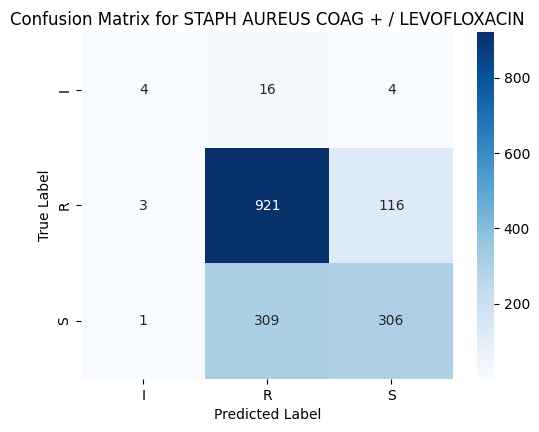


--- Generating Insights for STAPH AUREUS COAG + / LEVOFLOXACIN ---

Top 5 Most Important Features:
                    Feature  Importance
2          AVG_WBC_FIRST24H    0.182624
0          AGE_AT_ADMISSION    0.179135
1   AVG_CREATININE_FIRST24H    0.164688
3  AVG_BICARBONATE_FIRST24H    0.156042
4     HAD_PRIOR_ANTIBIOTICS    0.031754

================ Processing Pair 9614/10: STAPH AUREUS COAG + / ERYTHROMYCIN ================

Processing data for STAPH AUREUS COAG + / ERYTHROMYCIN...


/var/tmp/ipykernel_16006/2980027711.py:64: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_labevents_filtered['HADM_ID'] = df_labevents_filtered['HADM_ID'].astype(int)
/var/tmp/ipykernel_16006/2980027711.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_diagnoses_filtered['DIABETES_FLAG'] = df_diagnoses_filtered['ICD9_CODE'].str.startswith('250').astype(int)


Finished processing for STAPH AUREUS COAG + / ERYTHROMYCIN. Final DataFrame shape: (6479, 14)

--- Starting EDA for STAPH AUREUS COAG + / ERYTHROMYCIN ---

Target variable distribution (INTERPRETATION):
{'R': 4515, 'S': 1829, 'I': 135, 'P': 0}

--- Applying Outlier Capping for STAPH AUREUS COAG + / ERYTHROMYCIN ---

--- Starting Preprocessing for STAPH AUREUS COAG + / ERYTHROMYCIN ---

--- Starting Model Training & Validation for STAPH AUREUS COAG + / ERYTHROMYCIN ---
Performing Cross-Validation...
Mean CV F1-Weighted: 0.6915
Training final model...

--- Evaluating Model for STAPH AUREUS COAG + / ERYTHROMYCIN ---

Classification Report:
              precision    recall  f1-score   support

           I       0.47      0.21      0.29        34
           R       0.77      0.93      0.84      1129
           S       0.69      0.36      0.47       457

    accuracy                           0.75      1620
   macro avg       0.64      0.50      0.53      1620
weighted avg       0.74      

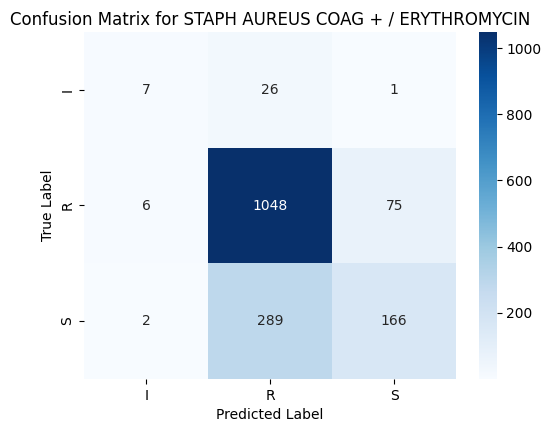


--- Generating Insights for STAPH AUREUS COAG + / ERYTHROMYCIN ---

Top 5 Most Important Features:
                    Feature  Importance
2          AVG_WBC_FIRST24H    0.185675
0          AGE_AT_ADMISSION    0.178579
3  AVG_BICARBONATE_FIRST24H    0.170249
1   AVG_CREATININE_FIRST24H    0.165571
5              HAS_DIABETES    0.026010

================ Processing Pair 9612/10: STAPH AUREUS COAG + / CLINDAMYCIN ================

Processing data for STAPH AUREUS COAG + / CLINDAMYCIN...


/var/tmp/ipykernel_16006/2980027711.py:64: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_labevents_filtered['HADM_ID'] = df_labevents_filtered['HADM_ID'].astype(int)
/var/tmp/ipykernel_16006/2980027711.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_diagnoses_filtered['DIABETES_FLAG'] = df_diagnoses_filtered['ICD9_CODE'].str.startswith('250').astype(int)


Finished processing for STAPH AUREUS COAG + / CLINDAMYCIN. Final DataFrame shape: (5028, 14)

--- Starting EDA for STAPH AUREUS COAG + / CLINDAMYCIN ---

Target variable distribution (INTERPRETATION):
{'R': 2679, 'S': 2347, 'I': 2, 'P': 0}

--- Applying Outlier Capping for STAPH AUREUS COAG + / CLINDAMYCIN ---

--- Starting Preprocessing for STAPH AUREUS COAG + / CLINDAMYCIN ---
Class with minimum count (2) is less than N_SPLITS_CV (5) for STAPH AUREUS COAG + / CLINDAMYCIN in the full dataset. Skipping modeling.

================ Processing Pair 9627/10: STAPH AUREUS COAG + / TETRACYCLINE ================

Processing data for STAPH AUREUS COAG + / TETRACYCLINE...


/var/tmp/ipykernel_16006/2980027711.py:64: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_labevents_filtered['HADM_ID'] = df_labevents_filtered['HADM_ID'].astype(int)
/var/tmp/ipykernel_16006/2980027711.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_diagnoses_filtered['DIABETES_FLAG'] = df_diagnoses_filtered['ICD9_CODE'].str.startswith('250').astype(int)


Finished processing for STAPH AUREUS COAG + / TETRACYCLINE. Final DataFrame shape: (4193, 14)

--- Starting EDA for STAPH AUREUS COAG + / TETRACYCLINE ---

Target variable distribution (INTERPRETATION):
{'S': 3972, 'R': 220, 'I': 1, 'P': 0}

--- Applying Outlier Capping for STAPH AUREUS COAG + / TETRACYCLINE ---

--- Starting Preprocessing for STAPH AUREUS COAG + / TETRACYCLINE ---
Class with minimum count (1) is less than N_SPLITS_CV (5) for STAPH AUREUS COAG + / TETRACYCLINE in the full dataset. Skipping modeling.

================ Processing Pair 9622/10: STAPH AUREUS COAG + / PENICILLIN ================

Processing data for STAPH AUREUS COAG + / PENICILLIN...


/var/tmp/ipykernel_16006/2980027711.py:64: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_labevents_filtered['HADM_ID'] = df_labevents_filtered['HADM_ID'].astype(int)
/var/tmp/ipykernel_16006/2980027711.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_diagnoses_filtered['DIABETES_FLAG'] = df_diagnoses_filtered['ICD9_CODE'].str.startswith('250').astype(int)


Finished processing for STAPH AUREUS COAG + / PENICILLIN. Final DataFrame shape: (4069, 14)

--- Starting EDA for STAPH AUREUS COAG + / PENICILLIN ---

Target variable distribution (INTERPRETATION):
{'R': 4003, 'S': 66, 'P': 0, 'I': 0}

--- Applying Outlier Capping for STAPH AUREUS COAG + / PENICILLIN ---

--- Starting Preprocessing for STAPH AUREUS COAG + / PENICILLIN ---

--- Starting Model Training & Validation for STAPH AUREUS COAG + / PENICILLIN ---
Performing Cross-Validation...
Mean CV F1-Weighted: 0.9785
Training final model...

--- Evaluating Model for STAPH AUREUS COAG + / PENICILLIN ---

Classification Report:
              precision    recall  f1-score   support

           R       0.99      1.00      0.99      1001
           S       1.00      0.24      0.38        17

    accuracy                           0.99      1018
   macro avg       0.99      0.62      0.69      1018
weighted avg       0.99      0.99      0.98      1018

Test Set F1-Weighted Score: 0.9833

Confusio

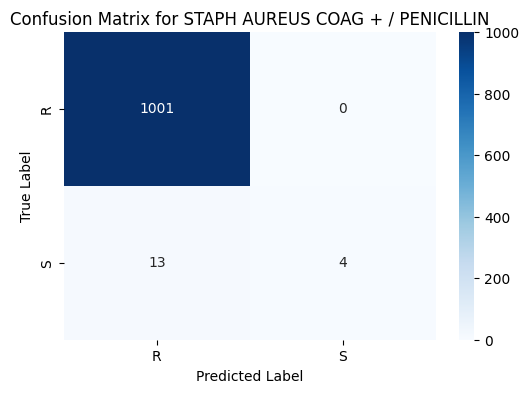


--- Generating Insights for STAPH AUREUS COAG + / PENICILLIN ---

Top 5 Most Important Features:
                    Feature  Importance
2          AVG_WBC_FIRST24H    0.162217
0          AGE_AT_ADMISSION    0.156591
3  AVG_BICARBONATE_FIRST24H    0.151228
1   AVG_CREATININE_FIRST24H    0.140259
4     HAD_PRIOR_ANTIBIOTICS    0.079369

================ Processing Pair 9630/10: STAPH AUREUS COAG + / VANCOMYCIN ================

Processing data for STAPH AUREUS COAG + / VANCOMYCIN...


/var/tmp/ipykernel_16006/2980027711.py:64: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_labevents_filtered['HADM_ID'] = df_labevents_filtered['HADM_ID'].astype(int)
/var/tmp/ipykernel_16006/2980027711.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_diagnoses_filtered['DIABETES_FLAG'] = df_diagnoses_filtered['ICD9_CODE'].str.startswith('250').astype(int)


Finished processing for STAPH AUREUS COAG + / VANCOMYCIN. Final DataFrame shape: (4123, 14)

--- Starting EDA for STAPH AUREUS COAG + / VANCOMYCIN ---

Target variable distribution (INTERPRETATION):
{'S': 4113, 'I': 10, 'P': 0, 'R': 0}

--- Applying Outlier Capping for STAPH AUREUS COAG + / VANCOMYCIN ---

--- Starting Preprocessing for STAPH AUREUS COAG + / VANCOMYCIN ---

--- Starting Model Training & Validation for STAPH AUREUS COAG + / VANCOMYCIN ---
Performing Cross-Validation...
Mean CV F1-Weighted: 0.9970
Training final model...

--- Evaluating Model for STAPH AUREUS COAG + / VANCOMYCIN ---

Classification Report:
              precision    recall  f1-score   support

           I       0.40      0.67      0.50         3
           S       1.00      1.00      1.00      1028

    accuracy                           1.00      1031
   macro avg       0.70      0.83      0.75      1031
weighted avg       1.00      1.00      1.00      1031

Test Set F1-Weighted Score: 0.9966

Confusio

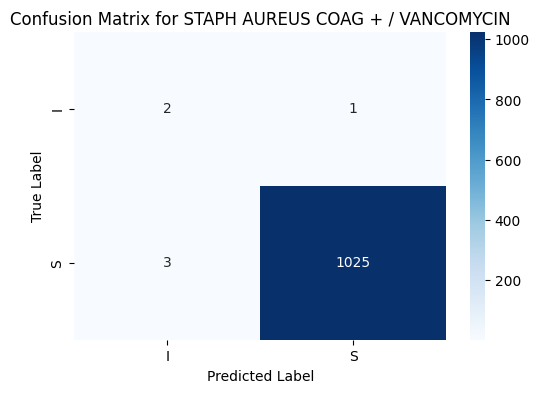


--- Generating Insights for STAPH AUREUS COAG + / VANCOMYCIN ---

Top 5 Most Important Features:
                         Feature  Importance
1        AVG_CREATININE_FIRST24H    0.228347
3       AVG_BICARBONATE_FIRST24H    0.142716
2               AVG_WBC_FIRST24H    0.136160
0               AGE_AT_ADMISSION    0.125226
10  SPEC_TYPE_DESC_BLOOD CULTURE    0.088965

================ Processing Pair 9626/10: STAPH AUREUS COAG + / RIFAMPIN ================

Processing data for STAPH AUREUS COAG + / RIFAMPIN...


/var/tmp/ipykernel_16006/2980027711.py:64: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_labevents_filtered['HADM_ID'] = df_labevents_filtered['HADM_ID'].astype(int)
/var/tmp/ipykernel_16006/2980027711.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_diagnoses_filtered['DIABETES_FLAG'] = df_diagnoses_filtered['ICD9_CODE'].str.startswith('250').astype(int)


Finished processing for STAPH AUREUS COAG + / RIFAMPIN. Final DataFrame shape: (3962, 14)

--- Starting EDA for STAPH AUREUS COAG + / RIFAMPIN ---

Target variable distribution (INTERPRETATION):
{'S': 3850, 'R': 86, 'I': 26, 'P': 0}

--- Applying Outlier Capping for STAPH AUREUS COAG + / RIFAMPIN ---

--- Starting Preprocessing for STAPH AUREUS COAG + / RIFAMPIN ---

--- Starting Model Training & Validation for STAPH AUREUS COAG + / RIFAMPIN ---
Performing Cross-Validation...
Mean CV F1-Weighted: 0.9647
Training final model...

--- Evaluating Model for STAPH AUREUS COAG + / RIFAMPIN ---

Classification Report:
              precision    recall  f1-score   support

           I       1.00      0.17      0.29         6
           R       0.83      0.45      0.59        22
           S       0.98      1.00      0.99       963

    accuracy                           0.98       991
   macro avg       0.94      0.54      0.62       991
weighted avg       0.98      0.98      0.98       991

T

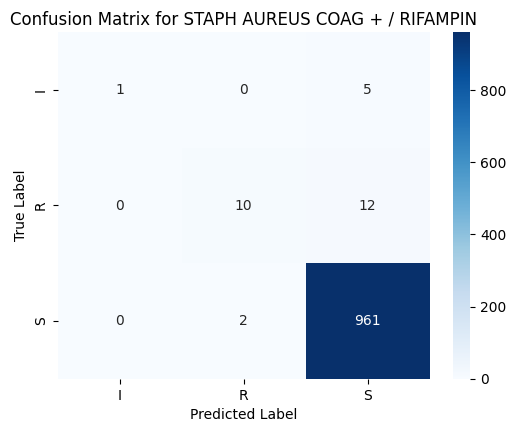


--- Generating Insights for STAPH AUREUS COAG + / RIFAMPIN ---

Top 5 Most Important Features:
                    Feature  Importance
2          AVG_WBC_FIRST24H    0.167343
0          AGE_AT_ADMISSION    0.163112
3  AVG_BICARBONATE_FIRST24H    0.162699
1   AVG_CREATININE_FIRST24H    0.139951
5              HAS_DIABETES    0.040820

================ Processing Pair 4065/10: ESCHERICHIA COLI / GENTAMICIN ================

Processing data for ESCHERICHIA COLI / GENTAMICIN...


/var/tmp/ipykernel_16006/2980027711.py:64: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_labevents_filtered['HADM_ID'] = df_labevents_filtered['HADM_ID'].astype(int)
/var/tmp/ipykernel_16006/2980027711.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_diagnoses_filtered['DIABETES_FLAG'] = df_diagnoses_filtered['ICD9_CODE'].str.startswith('250').astype(int)


Finished processing for ESCHERICHIA COLI / GENTAMICIN. Final DataFrame shape: (3505, 14)

--- Starting EDA for ESCHERICHIA COLI / GENTAMICIN ---

Target variable distribution (INTERPRETATION):
{'S': 3045, 'R': 429, 'I': 31, 'P': 0}

--- Applying Outlier Capping for ESCHERICHIA COLI / GENTAMICIN ---

--- Starting Preprocessing for ESCHERICHIA COLI / GENTAMICIN ---

--- Starting Model Training & Validation for ESCHERICHIA COLI / GENTAMICIN ---
Performing Cross-Validation...
Mean CV F1-Weighted: 0.8565
Training final model...

--- Evaluating Model for ESCHERICHIA COLI / GENTAMICIN ---

Classification Report:
              precision    recall  f1-score   support

           I       0.00      0.00      0.00         8
           R       0.79      0.21      0.34       107
           S       0.89      0.99      0.94       762

    accuracy                           0.89       877
   macro avg       0.56      0.40      0.43       877
weighted avg       0.87      0.89      0.86       877

Test S

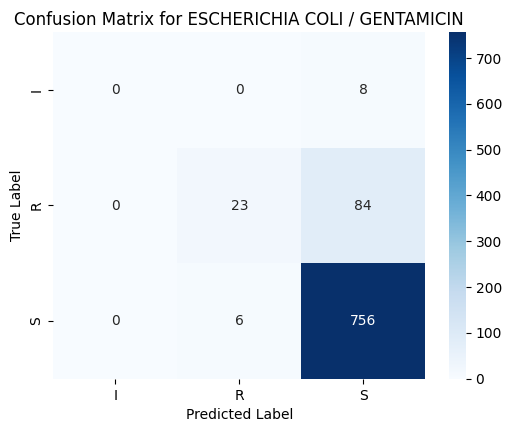


--- Generating Insights for ESCHERICHIA COLI / GENTAMICIN ---

Top 5 Most Important Features:
                        Feature  Importance
2              AVG_WBC_FIRST24H    0.169332
0              AGE_AT_ADMISSION    0.156132
3      AVG_BICARBONATE_FIRST24H    0.154887
1       AVG_CREATININE_FIRST24H    0.148444
9  SPEC_TYPE_DESC_BLOOD CULTURE    0.034061

================ Analysis Loop Complete ================


In [52]:
# --- Loop Through Top Pairs ---
print("\n--- Starting Analysis Loop for Top Pairs ---")
for index, row in top_pairs_df.iterrows():
    TARGET_ORG = row['ORG_NAME']
    TARGET_AB_NAME = row['AB_NAME']
    pair_label = f"{TARGET_ORG} / {TARGET_AB_NAME}"
    print(f"\n================ Processing Pair {index+1}/{TOP_N_PAIRS}: {pair_label} ================")

    # --- 1b. Data Processing for the current pair ---
    print(f"\nProcessing data for {pair_label}...")

    # 1. Filter Microbiology for the current target pair
    relevant_micro = df_micro_filtered[
        (df_micro_filtered['ORG_NAME'] == TARGET_ORG) &
        (df_micro_filtered['AB_NAME'] == TARGET_AB_NAME)
    ].copy()

    if relevant_micro.empty:
        print(f"No data found for {pair_label} after initial filtering. Skipping.")
        results_store[pair_label] = {'status': 'Skipped - No Micro Data'}
        continue

    target_col = 'INTERPRETATION'
    relevant_micro = relevant_micro[['SUBJECT_ID', 'HADM_ID', 'CHARTTIME', 'SPEC_TYPE_DESC', target_col]].dropna(subset=['HADM_ID', 'CHARTTIME', target_col]).rename(columns={'CHARTTIME': 'CULTURE_CHARTTIME'})
    relevant_micro['HADM_ID'] = relevant_micro['HADM_ID'].astype(int)

    # 2. Merge basic patient/admission info
    base_df = pd.merge(relevant_micro, df_admissions[['SUBJECT_ID', 'HADM_ID', 'ADMITTIME', 'ADMISSION_TYPE', 'ETHNICITY']], on=['SUBJECT_ID', 'HADM_ID'], how='inner')
    base_df = pd.merge(base_df, df_patients[['SUBJECT_ID', 'GENDER', 'DOB']], on='SUBJECT_ID', how='inner')

    if base_df.empty:
        print(f"No matching admission/patient data found for {pair_label}. Skipping.")
        results_store[pair_label] = {'status': 'Skipped - No Adm/Pat Data'}
        del relevant_micro
        gc.collect()
        continue

    # --- Age Calculation ---
    valid_dates_mask = base_df['ADMITTIME'].notna() & base_df['DOB'].notna()
    age_years = (base_df.loc[valid_dates_mask, 'ADMITTIME'].dt.year -
                 base_df.loc[valid_dates_mask, 'DOB'].dt.year)
    base_df['AGE_AT_ADMISSION'] = np.nan
    base_df.loc[valid_dates_mask, 'AGE_AT_ADMISSION'] = age_years
    base_df['AGE_AT_ADMISSION'] = base_df['AGE_AT_ADMISSION'].clip(lower=0, upper=90)
    if base_df['AGE_AT_ADMISSION'].isnull().any():
         median_age = base_df['AGE_AT_ADMISSION'].median()
         if pd.notna(median_age):
             print(f"Filling {base_df['AGE_AT_ADMISSION'].isnull().sum()} NaN ages with median age: {median_age:.1f}")
             base_df['AGE_AT_ADMISSION'].fillna(median_age, inplace=True)
         else:
             print(f"Warning: Could not calculate median age for {pair_label}. Filling NaNs with 0.")
             base_df['AGE_AT_ADMISSION'].fillna(0, inplace=True)
    # --- End of Age Calculation ---

    base_df['TIME_WINDOW_END'] = base_df['CULTURE_CHARTTIME'] + timedelta(hours=TIME_WINDOW_HOURS)
    base_df['PRIOR_ABX_WINDOW_START'] = base_df['CULTURE_CHARTTIME'] - timedelta(days=PRIOR_ANTIBIOTIC_LOOKBACK_DAYS)

    # 3. Process Labs
    lab_itemids = {'CREATININE': [50912, 50811], 'WBC': [51301], 'BICARBONATE': [50882]}
    lab_features = []
    current_hadm_ids = base_df['HADM_ID'].unique()
    df_labevents_filtered = df_labevents_full[df_labevents_full['HADM_ID'].isin(current_hadm_ids) & df_labevents_full['VALUENUM'].notna()]
    if not df_labevents_filtered.empty:
        df_labevents_filtered['HADM_ID'] = df_labevents_filtered['HADM_ID'].astype(int)
        merged_labs = pd.merge(base_df[['HADM_ID', 'CULTURE_CHARTTIME', 'TIME_WINDOW_END']].drop_duplicates(),
                               df_labevents_filtered[['HADM_ID', 'ITEMID', 'CHARTTIME', 'VALUENUM']],
                               on='HADM_ID', how='left')
        valid_labs = merged_labs[
            (merged_labs['CHARTTIME'] >= merged_labs['CULTURE_CHARTTIME']) &
            (merged_labs['CHARTTIME'] <= merged_labs['TIME_WINDOW_END']) &
            merged_labs['CHARTTIME'].notna()
        ]
        aggregated_labs = pd.DataFrame(index=pd.Index(current_hadm_ids, name='HADM_ID')) 
        for name, itemids in lab_itemids.items():
            feature_name = f'AVG_{name}_FIRST24H'
            lab_subset = valid_labs[valid_labs['ITEMID'].isin(itemids)]
            mean_vals = lab_subset.groupby('HADM_ID')['VALUENUM'].mean()
            aggregated_labs[feature_name] = mean_vals
            lab_features.append(feature_name)

        base_df = pd.merge(base_df, aggregated_labs, left_on='HADM_ID', right_index=True, how='left')
        del merged_labs, valid_labs, df_labevents_filtered, aggregated_labs
    else:
        print(f"No relevant lab events found for HADM_IDs in {pair_label}.")
        for name in lab_itemids.keys():
             feature_name = f'AVG_{name}_FIRST24H'
             base_df[feature_name] = np.nan
             lab_features.append(feature_name)

    # 4. Process Vitals (REMOVED due to memory constraints)
    vital_features = []

    # 5. Check for Prior Antibiotics
    abx_features = ['HAD_PRIOR_ANTIBIOTICS']
    df_prescriptions_filtered = df_prescriptions_full[df_prescriptions_full['HADM_ID'].isin(current_hadm_ids)]
    if not df_prescriptions_filtered.empty:
        df_prescriptions_filtered = df_prescriptions_filtered[df_prescriptions_filtered['DRUG_TYPE'].str.lower().isin(['main', 'antibiotic'])]
        merged_prescriptions = pd.merge(base_df[['HADM_ID', 'CULTURE_CHARTTIME', 'PRIOR_ABX_WINDOW_START']].drop_duplicates(),
                                        df_prescriptions_filtered[['HADM_ID', 'STARTDATE']],
                                        on='HADM_ID', how='left')
        valid_prescriptions = merged_prescriptions[
            (merged_prescriptions['STARTDATE'] >= merged_prescriptions['PRIOR_ABX_WINDOW_START']) &
            (merged_prescriptions['STARTDATE'] <= merged_prescriptions['CULTURE_CHARTTIME']) &
            merged_prescriptions['STARTDATE'].notna()
        ]
        prior_abx_flags = valid_prescriptions[['HADM_ID']].drop_duplicates()
        prior_abx_flags['HAD_PRIOR_ANTIBIOTICS'] = 1
        base_df = pd.merge(base_df, prior_abx_flags, on='HADM_ID', how='left')
        del merged_prescriptions, valid_prescriptions, prior_abx_flags
    base_df['HAD_PRIOR_ANTIBIOTICS'] = base_df['HAD_PRIOR_ANTIBIOTICS'].fillna(0).astype(int)
    del df_prescriptions_filtered

    # 6. Check for Comorbidities
    comorbidity_features = ['HAS_DIABETES']
    df_diagnoses_filtered = df_diagnoses_full[df_diagnoses_full['HADM_ID'].isin(current_hadm_ids) & df_diagnoses_full['ICD9_CODE'].notna()]
    if not df_diagnoses_filtered.empty:
        df_diagnoses_filtered['DIABETES_FLAG'] = df_diagnoses_filtered['ICD9_CODE'].str.startswith('250').astype(int)
        diabetes_flags = df_diagnoses_filtered.groupby('HADM_ID')['DIABETES_FLAG'].max().reset_index().rename(columns={'DIABETES_FLAG': 'HAS_DIABETES'})
        base_df = pd.merge(base_df, diabetes_flags, on='HADM_ID', how='left')
        del diabetes_flags
    base_df['HAS_DIABETES'] = base_df['HAS_DIABETES'].fillna(0).astype(int)
    del df_diagnoses_filtered

    # 7. Final DataFrame Assembly
    required_cols = [
        'SUBJECT_ID', 'HADM_ID', 'CULTURE_CHARTTIME', 'SPEC_TYPE_DESC', target_col,
        'GENDER', 'ADMISSION_TYPE', 'ETHNICITY', 'AGE_AT_ADMISSION'
    ] + lab_features + vital_features + abx_features + comorbidity_features

    for col in required_cols:
        if col not in base_df.columns:
             print(f"Warning: Column {col} not found for pair {pair_label}. Adding as NaN.")
             base_df[col] = np.nan

    df_final = base_df[required_cols].copy()
    df_final = df_final.drop_duplicates(subset=['HADM_ID', 'CULTURE_CHARTTIME'])
    df_final.dropna(subset=[target_col], inplace=True)

    print(f"Finished processing for {pair_label}. Final DataFrame shape: {df_final.shape}")

    # --- Check for sufficient data and classes BEFORE splitting ---
    y_raw_counts = df_final[target_col].value_counts()
    if df_final.empty or len(y_raw_counts) < 2:
         print(f"Not enough data or only one class present for {pair_label} BEFORE splitting. Skipping modeling.")
         results_store[pair_label] = {'status': 'Skipped - Insufficient Data/Classes Pre-Split'}
         del relevant_micro, base_df, df_final
         gc.collect()
         continue
    # --- End Check ---


    # --- 2. Exploratory Data Analysis (EDA) ---
    print(f"\n--- Starting EDA for {pair_label} ---")
    print(f"\nTarget variable distribution ({target_col}):")
    print(y_raw_counts.to_dict()) 

    identifier_cols = ['SUBJECT_ID', 'HADM_ID', 'CULTURE_CHARTTIME']
    all_features = [col for col in df_final.columns if col not in identifier_cols + [target_col]]
    numerical_features = df_final[all_features].select_dtypes(include=np.number).columns.tolist()
    categorical_features = df_final[all_features].select_dtypes(include=['object', 'category']).columns.tolist()

    # --- Outlier Handling ---
    print(f"\n--- Applying Outlier Capping for {pair_label} ---")
    df_processed = df_final.copy()
    for col in numerical_features:
        if df_processed[col].nunique(dropna=False) <= 2: continue
        if df_processed[col].isnull().all(): continue
        Q1 = df_processed[col].quantile(0.25)
        Q3 = df_processed[col].quantile(0.75)
        IQR = Q3 - Q1
        if pd.isna(IQR) or IQR == 0: continue
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        if pd.isna(lower_bound) or pd.isna(upper_bound): continue
        outliers_low = (df_processed[col] < lower_bound).fillna(False)
        outliers_high = (df_processed[col] > upper_bound).fillna(False)
        num_outliers = outliers_low.sum() + outliers_high.sum()
        if num_outliers > 0:
            df_processed[col] = df_processed[col].mask(outliers_low, lower_bound)
            df_processed[col] = df_processed[col].mask(outliers_high, upper_bound)

    # --- 3. Preprocessing ---
    print(f"\n--- Starting Preprocessing for {pair_label} ---")
    X = df_processed[all_features]
    y_raw = df_processed[target_col]
    y = target_encoder.transform(y_raw) # Encode target

    # <<< Check minimum class count in the entire dataset y for this pair >>>
    y_counts = Counter(y)
    min_class_count_full = y_counts.most_common()[-1][1] if y_counts else 0

    # Check if minimum count is less than N_SPLITS_CV (needed for stratification)
    if min_class_count_full < N_SPLITS_CV:
        print(f"Class with minimum count ({min_class_count_full}) is less than N_SPLITS_CV ({N_SPLITS_CV}) for {pair_label} in the full dataset. Skipping modeling.")
        results_store[pair_label] = {'status': f'Skipped - Min Class Count < {N_SPLITS_CV} (Full Set)'}
        # Clean up intermediate dfs specific to this iteration
        del X, y_raw, y, df_processed, df_final, relevant_micro, base_df
        gc.collect()
        continue # Move to the next pair
    # <<< End Check >>>


    numerical_features = X.select_dtypes(include=np.number).columns.tolist()
    categorical_features = X.select_dtypes(include=['object', 'category']).columns.tolist()

    numerical_transformer = Pipeline(steps=[('imputer', SimpleImputer(strategy='median')), ('scaler', StandardScaler())])
    categorical_transformer = Pipeline(steps=[('imputer', SimpleImputer(strategy='most_frequent')), ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))])
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', numerical_transformer, [f for f in numerical_features if f in X.columns]),
            ('cat', categorical_transformer, [f for f in categorical_features if f in X.columns])
        ],
        remainder='passthrough',
        verbose_feature_names_out=False
    )
    preprocessor.set_output(transform='pandas')

    # --- 4. Model Training & Validation ---
    print(f"\n--- Starting Model Training & Validation for {pair_label} ---")
    # Stratify based on the encoded numerical target 'y'
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42, stratify=y)

    # Double-check split didn't create single-class sets (less likely now with pre-check, but safe)
    if len(np.unique(y_train)) < 2 or len(np.unique(y_test)) < 2:
        print(f"Only one class present in train/test split for {pair_label} after encoding. Skipping modeling.")
        results_store[pair_label] = {'status': 'Skipped - Single Class Split'}
        del X, y_raw, y, X_train, X_test, y_train, y_test, df_processed, df_final, relevant_micro, base_df
        gc.collect()
        continue

    model_pipeline = Pipeline(steps=[('preprocessor', preprocessor), ('classifier', RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced', n_jobs=-1))])

    print("Performing Cross-Validation...")
    cv = StratifiedKFold(n_splits=N_SPLITS_CV, shuffle=True, random_state=42) 
    mean_cv_f1_weighted = np.nan
    # Check minimum class count in y_train BEFORE attempting CV
    y_train_counts = Counter(y_train)
    min_train_class_count = y_train_counts.most_common()[-1][1] if y_train_counts else 0

    # No need to check len(y_train_counts) > 1 because the earlier check ensures >= 2 classes
    if min_train_class_count >= N_SPLITS_CV:
        try:
             cv_scores = cross_val_score(model_pipeline, X_train, y_train, cv=cv, scoring='f1_weighted', n_jobs=-1, error_score='raise')
             mean_cv_f1_weighted = np.mean(cv_scores)
             print(f"Mean CV F1-Weighted: {mean_cv_f1_weighted:.4f}")
             cv_status = 'CV Completed'
        except Exception as e:
            print(f"Cross-validation failed for {pair_label} despite check: {e}")
            cv_status = f'CV Failed: {e}' # Record failure reason
    else:
        print(f"Skipping CV for {pair_label}: Not enough samples in minority class ({min_train_class_count}) for {N_SPLITS_CV} splits in training data.")
        cv_status = f'Skipped CV - Min Class < {N_SPLITS_CV}' # Record skip reason

    print("Training final model...")
    model_pipeline.fit(X_train, y_train)

    # --- 5. Evaluation ---
    print(f"\n--- Evaluating Model for {pair_label} ---")
    y_pred = model_pipeline.predict(X_test)
    test_f1_weighted = np.nan

    unique_labels_test, unique_counts_test = np.unique(y_test, return_counts=True)
    unique_target_names_test = target_encoder.inverse_transform(unique_labels_test)

    print("\nClassification Report:")
    if len(unique_labels_test) > 1:
         print(classification_report(y_test, y_pred,
                                     labels=unique_labels_test,
                                     target_names=unique_target_names_test,
                                     zero_division=0))
         test_f1_weighted = f1_score(y_test, y_pred, average='weighted', labels=unique_labels_test)
         print(f"Test Set F1-Weighted Score: {test_f1_weighted:.4f}")
    else:
        print("Skipping classification report: Only one class in test data.")


    # Confusion Matrix for Multiclass
    print("\nConfusion Matrix:")
    if len(unique_labels_test) > 0: # Ensure there's at least one class to plot
        cm = confusion_matrix(y_test, y_pred, labels=unique_labels_test)
        plt.figure(figsize=(max(6, len(unique_target_names_test)*2), max(4, len(unique_target_names_test)*1.5)))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                    xticklabels=unique_target_names_test,
                    yticklabels=unique_target_names_test)
        plt.xlabel('Predicted Label')
        plt.ylabel('True Label')
        plt.title(f'Confusion Matrix for {pair_label}')
        plt.show()
    else:
        print("Skipping confusion matrix: No data in test set.")


    # --- 6. Insight Generation ---
    print(f"\n--- Generating Insights for {pair_label} ---")
    top_features = []
    feature_importance_df = None
    try:
        feature_names = model_pipeline[:-1].get_feature_names_out()
        importances = model_pipeline.named_steps['classifier'].feature_importances_
        if len(feature_names) == len(importances):
            feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances}).sort_values(by='Importance', ascending=False)
            print("\nTop 5 Most Important Features:")
            print(feature_importance_df.head(5))
            top_features = feature_importance_df.head(5)['Feature'].tolist()
        else:
             print(f"Warning: Feature name ({len(feature_names)}) / importance ({len(importances)}) length mismatch.")
    except Exception as e:
        print(f"Could not extract feature importances: {e}")

    # --- Store Results ---
    # Determine final status based on whether CV was skipped/failed or completed
    final_status = cv_status if cv_status.startswith('Skipped') or cv_status.startswith('CV Failed') else 'Completed'

    results_store[pair_label] = {
        'status': final_status,
        'n_samples': len(df_final),
        'target_distribution': df_final[target_col].value_counts(normalize=True).to_dict(),
        'mean_cv_f1_weighted': mean_cv_f1_weighted, # Will be NaN if CV skipped/failed
        'test_f1_weighted': test_f1_weighted,
        'top_features': top_features,
        'feature_importances': feature_importance_df
    }

    # --- Clean up memory ---
    del X, y_raw, y, X_train, X_test, y_train, y_test, model_pipeline, df_processed, df_final
    del relevant_micro, base_df, feature_importance_df
    gc.collect()


# --- End of Loop ---
print("\n================ Analysis Loop Complete ================")

In [53]:
# --- Summarize Results ---
print("\n--- Summary of Results Across Top Pairs ---")
# Create DataFrame from the results store
results_summary_df = pd.DataFrame.from_dict(results_store, orient='index')

# Define expected columns and ensure they exist, adding NA if missing
expected_cols = ['status', 'n_samples', 'target_distribution', 'mean_cv_f1_weighted', 'test_f1_weighted', 'top_features']
for col in expected_cols:
    if col not in results_summary_df.columns:
        results_summary_df[col] = pd.NA

# Select and reorder columns
results_summary_df = results_summary_df[expected_cols]

# --- Enhanced Formatting and Explanation ---
# Create a copy for display formatting
results_display_df = results_summary_df.copy()

# Format target distribution for readability
def format_distribution(dist_dict):
    if pd.isna(dist_dict) or not isinstance(dist_dict, dict):
        return "N/A"
    return ', '.join([f"{k}: {v:.1%}" for k, v in sorted(dist_dict.items())])

results_display_df['target_distribution'] = results_display_df['target_distribution'].apply(format_distribution)

# Format F1 scores
results_display_df['mean_cv_f1_weighted'] = results_display_df['mean_cv_f1_weighted'].map('{:.4f}'.format).replace('nan', 'N/A')
results_display_df['test_f1_weighted'] = results_display_df['test_f1_weighted'].map('{:.4f}'.format).replace('nan', 'N/A')

# Format top features list
def format_top_features(feature_list):
    # Check if input is a list and not empty
    if isinstance(feature_list, list) and feature_list:
        # Truncate long feature names
        truncated_list = [f[:30] + '...' if len(f) > 33 else f for f in feature_list]
        return ', '.join(truncated_list)
    # Handle cases where feature_list might be NaN, None, or an empty list
    elif pd.isna(feature_list) or not feature_list:
         return "N/A"
    # Fallback for unexpected types (though less likely now)
    else:
        return "Invalid Format"


results_display_df['top_features'] = results_display_df['top_features'].apply(format_top_features)

# Rename columns for better display
results_display_df = results_display_df.rename(columns={
    'status': 'Status',
    'n_samples': 'N Samples',
    'target_distribution': 'Target Distr.',
    'mean_cv_f1_weighted': 'Mean CV F1 (W)',
    'test_f1_weighted': 'Test F1 (W)',
    'top_features': 'Top 5 Features (Approx.)'
})

# Sort by test F1 score (descending), putting NaNs/NAs last
# Convert F1 score back to numeric for sorting, handling 'N/A'
results_display_df['Test F1 (W)_sort'] = pd.to_numeric(results_display_df['Test F1 (W)'], errors='coerce')
results_display_df = results_display_df.sort_values(by='Test F1 (W)_sort', ascending=False, na_position='last').drop(columns=['Test F1 (W)_sort'])


print("\n--- Formatted Summary ---")
print("Explanation of Columns:")
print("- Status: Outcome of the modeling process for the pair (Completed, Skipped, CV Failed, etc.).")
print("- N Samples: Number of valid microbiology events used for modeling this pair.")
print("- Target Distr.: Distribution of target classes (R, S, I) in the dataset for this pair.")
print("- Mean CV F1 (W): Average Weighted F1-score from 5-fold cross-validation (if performed). 'N/A' if skipped or failed.")
print("- Test F1 (W): Weighted F1-score on the held-out test set. 'N/A' if evaluation failed.")
print("- Top 5 Features (Approx.): The most important features identified by the RandomForest model (names might be truncated).")
print("-" * 80) # Separator

# Display the formatted DataFrame
# Adjust display options if needed for wide tables
pd.set_option('display.max_colwidth', None) # Show full content of columns like features
pd.set_option('display.width', 120) # Adjust display width
print(results_display_df)
pd.reset_option('display.max_colwidth')
pd.reset_option('display.width')
print("\n--- Full Analysis Complete ---")


--- Summary of Results Across Top Pairs ---

--- Formatted Summary ---
Explanation of Columns:
- Status: Outcome of the modeling process for the pair (Completed, Skipped, CV Failed, etc.).
- N Samples: Number of valid microbiology events used for modeling this pair.
- Target Distr.: Distribution of target classes (R, S, I) in the dataset for this pair.
- Mean CV F1 (W): Average Weighted F1-score from 5-fold cross-validation (if performed). 'N/A' if skipped or failed.
- Test F1 (W): Weighted F1-score on the held-out test set. 'N/A' if evaluation failed.
- Top 5 Features (Approx.): The most important features identified by the RandomForest model (names might be truncated).
--------------------------------------------------------------------------------
                                                                      Status  N Samples  \
STAPH AUREUS COAG + / VANCOMYCIN                                   Completed     4123.0   
STAPH AUREUS COAG + / PENICILLIN                        